In [1]:
import pandas as pd
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 
from sklearn.metrics import classification_report


%matplotlib inline

In [2]:
nm = pd.read_pickle("data/all_calls17_uof_df.pkl")

# need to:
# make a y and make categories numeric(?)
# drop CAD and Event and Force
# make dummie columns
# cahnge month and day to integers


In [3]:
nm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1459754 entries, 0 to 3986667
Data columns (total 14 columns):
CAD_Event_Number               1459754 non-null int64
Event_Clearance_Description    1459754 non-null object
Force_Level                    1459754 non-null object
Precinct                       1459754 non-null object
Sector                         1449873 non-null object
Beat                           1459754 non-null object
Subject_Race                   1459754 non-null object
Subject_Gender                 1459754 non-null object
Call_Type                      1459754 non-null object
Initial_Call_Type              1459754 non-null object
month                          1459754 non-null object
day                            1459754 non-null object
day_of_week                    1459754 non-null int64
hour                           1459754 non-null int64
dtypes: int64(3), object(11)
memory usage: 167.1+ MB


In [4]:
y = nm.Force_Level
y.replace({"Level 1 - Use of Force":1,"Level 2 - Use of Force":2,"Level 3 - OIS":4, "Level 3 - Use of Force": 3 }, inplace=True)


In [5]:
# make a copy to alter for the model in case I want to look back at this
nm2 = nm.copy(deep=True)

In [6]:
# drop columns and make time ints
nm.drop(["Force_Level", "CAD_Event_Number", "Event_Clearance_Description"], axis=1, inplace=True)
nm["month"] = nm["month"].astype(int)
nm["day"] = nm["day"].astype(int)

In [7]:
# better categories in Initial Call Type

init = nm["Initial_Call_Type"]
to_drop = init[init.str.startswith("-ASSIGNED DUTY")]


s = nm["Initial_Call_Type"].str.replace(" - .*", "", regex=True)
nm["Initial_Call_Type"] = s

In [8]:
#drop = ["ASSIST PUBLIC", ]  -DOWN TIME - OUT OF SERVICE  

In [10]:
# cool EDA

call_types = nm.groupby(["Call_Type"]).Initial_Call_Type.value_counts()

df1 = nm[nm['cat_ICT'].str.contains("LITTERING") ]

vc = nm.cat_ICT.value_counts()
vc[70:]
#df1.cat_ICT.value_counts()

KeyError: 'cat_ICT'

In [97]:
# function for later to categorize ICT column

def initial_call_type_cats(value):    
    if "MVC" in value:
        return "Motor Vehicle Collision"
    elif value.startswith("FRAUD"):
        return "Fraud"
    elif "SUSPICIOUS STOP" in value:
        return "Police Initiated Stop"
    elif "SUSPICIOUS" in value:
        return "Suspicious person, vehicle, incident"
    elif "TRAFFIC STOP" in value:
        return "Polic Initiated Stop"
    elif "ROAD RAGE" in value:
        return "Road Rage"
    elif "MOVING VIOLATION" in value:
        return "Moving Violation"
    elif "TRAF" in value:
        return "Moving Violation"
    elif "BLOCKING ROADWAY" in value:
        return "Parking Violation"
    elif "TRAFFIC - ASSIST" in value:
        return "Assist Motorist"
    elif "DISTURBANCE" in value:
        return "Disturbance"
    elif "NOISE" in value:
        return "Disturbance"
    elif "OFF DUTY EMPLOYMENT" in value:
        return "Police Initiated - Off Duty"
    elif "NUISANCE" in value:
        return "Nuisance"
    elif "NARCOTICS" in value:
        return "Narcotics"
    elif "SEX IN PUBLIC" in value:
        return "Lewd Conduct"
    elif "VIOLATION OF COURT ORDER (NON DV)" in value:
        return "Violation of Court Order (Not Domestic Violence)"
    elif "NOT DV" in value:
        return "Alarm"
    elif "SHOTS" in value:
        return "Shots heard"
    elif "DV" in value:
        return "Domestic Violence"
    elif "ASSAULTS" in value:
        return "Assault"
    elif "WEAPN" in value:
        return "Deadly Weapon - No Assault"
    elif "ASLT" in value:
        return "Assault"
    elif "FIGHT" in value:
        return "Assault"
    elif "THEFT" in value:
        return "Robbery"
    elif "PREMISE CHECK" in value:
        return "Police Initiated"
    elif "DIRECTED PATROL ACTIVITY" in value:
        return "Assigned Duty"
    elif "UNUSUAL OCCURRENCES - EARTHQUAKE, RIOT, ETC)" in value:
        return "Disturbance"
    elif "PARKING" in value:
        return "Parking Violation"
    elif "ALARM"in value:
        return "Alarm"
    elif "BURG" in value:
        return "Robbery"
    elif "WATER FLOODS" in value:
        return "Nuisance"
    elif "TREES DOWN" in value:
        return "Nuisance"
    elif "HAZ" in value:
        return "Hazard - immediate threat"
    elif "TRESPASS" in value:
        return "Trespass"
    elif "FOLLOW" in value:
        return "Follow up"
    elif "WELFARE" in value:
        return "Welfare Check"
    elif "SERVICE" in value:
        return "Assisting other agencies"
    elif "SFD" in value:
        return "Assisting other agencies"
    elif "SUICIDE" in value:
        return "Suicidal person or attempts"
    elif "LIQUOR" in value:
        return "Liquor Violations"
    elif "AUTO" in value:
        return "Auto Recovery"
    elif "DAMAGE" in value:
        return "Damaged Property"
    elif "DAMG" in value:
        return "Damaged Property"
    elif "PROPERTY" in value:
        return "Property lost or found"
    elif "FOLLOW UP" in value:
        return "Follow up"
    elif "PERSON IN BEHAVIORAL/EMOTIONAL CRISIS" in value:
        return "Behavioral / Emotional Crisis"
    elif "DOWN - CHECK" in value:
        return "Check for Person Down"
    elif "SICK" in value:
        return "-"
    elif "--PERSON" in value:
        return "Missing Person"
    elif "INJURED" in value:
        return "Injuries from Industrial Accidents"
    elif "PICKUP" in value:
        return "Pickup Person"
    elif "BOMB" in value:
        return "Threats"
    elif "THREAT" in value:
        return "Threats"
    elif "RAPE" in value:
        return "Rape"
    elif "ROBBERY" in value:
        return "Robbery"
    elif "KIDNAPPING" in value:
        return "Missing Person"
    elif "MISSING" in value:
        return "Missing Person"
    elif "PROWLER" in value:
        return "Suspicious person, vehicle, incident"
    elif "PANHANDLING" in value:
        return "Aggressive Panhandling"
    elif "RUNAWAY" in value:
        return "Missing Person"
    elif "ASSIGNED DUTY" in value:
        return "Assigned Duty"
    elif "KIDNAPPNG" in value:
        return "Missing Person"
    elif "LEWD" in value:
        return "Lewd Conduct"
    elif "OVERDOSE" in value:
        return "Overdose - Drug Related Casualty"
    elif "PREDICTIVE POLICING" in value:
        return "Predictive Policing"
    elif "DETOX" in value:
        return "Request for Detox"
    elif "REQUEST" in value:
        return "Request to Watch / Ensure Peace"
    elif "CHILD" in value:
        return "Child Abuse"
    elif "PURSE" in value:
        return "Robbery"
    elif "PEACE" in value:
        return "Request to Watch / Ensure Peace"
    elif "DEAD" in value:
        return "Casualty"
    elif "GAMBLING" in value:
        return "Gambling"
    elif "ANIMAL" in value:
        return "Animal - Dangerous / Bite"
    elif "ESCAPE" in value:
        return "-"
    elif "PARKS" in value:
        return "Parks Violations"
    elif "PROSTITUTION" in value:
        return "Prostitution"
    elif "Pornography" in value:
        return "Lewd Conduct"
    elif "DUI" in value:
        return "DUI - Driving While Under the Influence"
    elif "SEX OFFENDER" in value:
        return "Sex Offender - Failure to Register"
    elif "SEX" in value:
        return "-"
    elif "SLEEP" in value:
        return "Sleeper Aboard Public Transit"
    elif "HARASSMENT" in value:
        return "Harassment"
    elif "EXPLOSION" in value:
        return "Explosion / Arson"
    elif "ARSON" in value:
        return "Explosion / Arson"
    elif "PREPLANNED" in value:
        return "Assigned Duty"
    elif "ASSIGNMENT" in value:
        return "Assigned Duty"
    elif "SHOPLIFT" in value:
        return "Robbery"
    elif "ELUDING" in value:
        return "Eluding Police"
    elif "LITTERING" in value:
        return "Illegal Dumping"
    elif "DUMPING" in value:
        return "Illegal Dumping"
    elif "BURN" in value:
        return "Explosion / Arson"
    else:
        return "-"
    
    
    

In [ ]:
# calling above function to make list to make column
new_col = []
for idx, row in nm2.iterrows():
    value = row.Initial_Call_Type
    new_col.append(initial_call_type_cats(value))

In [ ]:
nm2["cat_ICT"] = new_col


In [71]:

# Get nums of indexes for which column has '-'
indexnums = nm[ nm['cat_ICT'] == '-'].index
nm.drop(indexnums,  inplace=True)

In [89]:
len(nm2), len(nm)

(1265136, 1459754)

In [ ]:
#nm2["cat_ICT"] = new_col
nmvc2 = nm2.groupby("cat_ICT")
lst = nmvc2.Force_Level.value_counts()
nmvc3 = nm2.groupby("Force_Level")
lst2 = nmvc3.cat_ICT.value_counts()
lst[["Assault", "Fight - with weapons", "Fight - no weapons"]]

In [30]:

nmvc = nm["cat_ICT"].value_counts()
nmvc.index

Index(['Police Initiated', '-', 'Robbery', 'Disturbance',
       'Suspicious person, vehicle, incident', 'Motor Vehicle Collision',
       'Alarm', 'Directed Patrol Activity', 'Assault', 'Nuisance',
       'Parking Violation', 'Trespass', 'Property lost or found', 'Follow up',
       'Assisting other agencies', 'Assigned Duty', 'Fight - no weapons',
       'Moving Violation', 'Narcotics', 'Hazard - immediate threat',
       'Auto Recovery', 'Threats', 'Suicidal person or attempts',
       'Behavioral / Emotional Crisis', 'Liquor Violations', 'Fraud',
       'Shots heard', 'Request to Watch', 'Deadly Weapon - No Assault',
       'Lewd Conduct', 'Child Abuse', 'Missing Person',
       'Overdose - Drug Related Casualty', 'Predictive Policing',
       'Request for Detox', 'Prowler', 'Standby to Ensure Peace',
       'Animal - Dangerous / Bite', 'DUI - Driving While Under the Influence',
       'Aggressive Panhandling', 'Parks Violations', 'Rape', 'Arson',
       'Sex Offender - Failure to 

In [35]:
nmvc = nm["cat_ICT"].value_counts()
list(nmvc)

nm.groupby("cat_ICT")["Force_Level"].value_counts()

KeyError: 'Column not found: Force_Level'

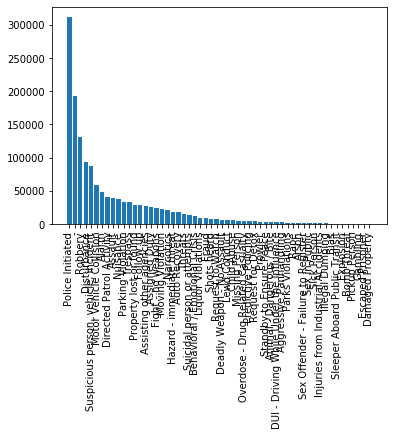

In [33]:
plt.bar(nmvc.index, list(nmvc))
plt.xticks(rotation="vertical");

In [ ]:
# get dummies for string valued columns
nm = pd.get_dummies(data = nm, 
                     columns=["Precinct", "Sector", "Beat", "Subject_Gender", "Subject_Race", "Call_Type", 
                               "Initial_Call_Type"], 
                     prefix=["P",  "S", "B", "SG", "SR","CT", "ICT"])

In [ ]:
# dropping the "-" Precinct and Sector columns - they aren't useful for interpretation

nm.drop(["S_-", "P_-"], axis=1, inplace=True)

In [ ]:
# dropping column

nm.drop(['SG_-', 'SR_-'], axis=1, inplace=True)

In [ ]:
# get column names to identify features in feature_importance later

cols = nm.columns

In [ ]:
# two minutes~

X_scaled = StandardScaler().fit_transform(nm)

In [ ]:
# will need to change nm2 to X_scaled if we use this later - X_scaled hung and never finished (~10minutes)

X_train, X_test, y_train, y_test = train_test_split(nm, y, test_size=0.2, random_state=659)

In [ ]:
# create RFC model - change all but random_state after we time this one

clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=659, oob_score=True)



In [ ]:
# fit the model

clf.fit(X_train, y_train)

In [ ]:
# check the feature importances and col_name list match first

len(clf.feature_importances_), len(cols)

In [ ]:
# most important features in predictions of this model

indices = np.argsort(clf.feature_importances_)
big = indices[-1:-20:-1]

cols[big]

In [ ]:
# least important features
little = indices[:10]
cols[little]


In [ ]:
clf.oob_score_ # accuracy of training set

In [ ]:
# predicted classes

yhat = clf.predict(X_test)

In [ ]:
sum(yhat == y_test) / len(yhat) # accuracy of testing set

In [ ]:
# sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(classification_report(y_test, yhat))


In [ ]:
# predict probabilities - what do you want threshold to be?

pp = clf.predict_proba(X_test)

In [ ]:
clf.classes_

In [ ]:
# some rows' probabilities of being in each class:

for p in pp[:10]:
    print(f"Pr of no force is: {p[0]}, Pr of Force 1 is: {p[1]}, Pr of Force 2: {p[2]}, Pr of Force 3: {p[3]}, & Pr of Officer Involved Shooting: {p[4]}")
          
          

In [ ]:
len(y_test)

In [ ]:
type(y_test)

In [ ]:
y_test[y_test == 4]

In [ ]:
type(yhat)

In [ ]:
len(yhat[yhat == 4])

In [ ]:
yhat[50706]

In [ ]:
# visualization - you can plot the abundance/frequency of each selected feature within each group as a bar plot. 
# I assume visually the top feature will be more abundant in one group comparing with the other groups.

four = y_test[y_test == 4]
four, four.index

In [ ]:
fourX = X_test.iloc[[50706, 220355, 156571, 60263, 6215, 156570, 102803, 50750, 220432,
        50774],:]
fourX


In [ ]:
fournm = nm2.iloc[50706,:]
fournm

four_index = [50706, 220355, 156571, 60263, 6215, 156570, 102803, 50750, 220432,
        50774]

nm2[nm2.index.isin(four_index)]

In [ ]:
fournm.info()